<a href="https://colab.research.google.com/github/buriro-ezekia/-Hepatitis-B-Predictive-Modelling-and-Forecasting-Benjamin-Mkapa-Hospital-BMH-/blob/main/BMH_Longitudinal_Data_III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**General objective**

The goal of this study is developing a Predictive model for Hepatitis B patients using hospital-records data from 2017 to 2024 at Benjamin Mkapa Hospital.

**Specific objective**

- To analyse hepatitis B patient trends at Benjamin Mkapa Hospital (BMH)
- To develop a Hepatitis B patient predictive model.
- To predict Hepatitis B patients at BMH over the next five years.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Data Cleaning**

In [ ]:
import pandas as pd

# Load the raw patient-level data
df = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_CLEANED_ready.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710 entries, 0 to 1709
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   OPIP_CODE       1710 non-null   object 
 1   UHID            1710 non-null   object 
 2   REGN_DT         1710 non-null   object 
 3   GENDER          1710 non-null   int64  
 4   AGE             1710 non-null   int64  
 5   VIRAL_LOAD      1710 non-null   float64
 6   ALT_LEVEL       1710 non-null   float64
 7   VIRAL_LOAD_LOG  1710 non-null   float64
dtypes: float64(3), int64(2), object(3)
memory usage: 107.0+ KB


In [ ]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_CLEANED_ready.csv")

# 1. Remove Duplicates
df = df.drop_duplicates()

# 2. Correct Errors and Ensure Consistency in Patient IDs and Date Formats
# Standardize OPIP_CODE and UHID (remove spaces, uppercase)
df["OPIP_CODE"] = df["OPIP_CODE"].str.strip().str.upper()
df["UHID"] = df["UHID"].str.strip().str.upper()

# Convert REGN_DT to datetime
df["REGN_DT"] = pd.to_datetime(df["REGN_DT"],format='%d-%b-%Y %H.%M.%S', errors="coerce")
# Optionally drop rows with invalid dates
df = df.dropna(subset=["REGN_DT"])

# 3. Identify & Mark LTFU (Lost to Follow-Up)
# Assume you define LTFU as missing latest viral load or ALT_LEVEL, or by a rule (e.g., last visit > 12 months ago)
# Example: If REGN_DT is > 12 months from "today", mark as LTFU
today = pd.Timestamp.today()
df["LTFU"] = (today - df["REGN_DT"]).dt.days > 365  # LTFU if last visit > 1 year ago

# 4. MNAR Considerations
# Explore correlates of missingness, e.g. for VIRAL_LOAD or ALT_LEVEL
missing_vl = df["VIRAL_LOAD"].isna()
missing_alt = df["ALT_LEVEL"].isna()

# Check if missingness is related to gender, age, viral load, etc.
mnar_summary = df[missing_vl | missing_alt][["GENDER", "AGE", "VIRAL_LOAD", "ALT_LEVEL"]].describe(include="all")

# Document MNAR findings (print or save as a separate file)
mnar_summary.to_csv("drive/MyDrive/Rulinga II/MNAR_summary.csv")

# Optionally, fill missing values or leave them as is, depending on your analysis plan

# Save the cleaned dataset
df.to_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_CLEANED_final.csv", index=False)

print("Data cleaning complete. Cleaned file saved as DIAGNOSIS_RESULTS_CLEANED_final.csv.")
print("MNAR summary saved as MNAR_summary.csv.")

Data cleaning complete. Cleaned file saved as DIAGNOSIS_RESULTS_CLEANED_final.csv.
MNAR summary saved as MNAR_summary.csv.


### Time Series Structuring

In [ ]:
import pandas as pd
import numpy as np

# Load cleaned dataset
df = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_CLEANED_final.csv", parse_dates=["REGN_DT"])

# 1. Monthly Aggregation (one row per patient per month)
df['month'] = df['REGN_DT'].dt.to_period('M')
monthly_df = df.groupby(['OPIP_CODE', 'month']).agg({
    'UHID': 'first',
    'GENDER': 'first',
    'AGE': 'first',
    'VIRAL_LOAD': 'mean',
    'ALT_LEVEL': 'mean',
    'VIRAL_LOAD_LOG': 'mean',
    'LTFU': 'max'
}).reset_index()
monthly_df['month'] = monthly_df['month'].dt.to_timestamp()
monthly_df = monthly_df.sort_values(['OPIP_CODE', 'month'])

# 2. Track Follow-Up (start/end times, duration)
followup_stats = df.groupby('OPIP_CODE')['REGN_DT'].agg(['min', 'max', 'count']).reset_index()
followup_stats['duration_days'] = (followup_stats['max'] - followup_stats['min']).dt.days
followup_stats.rename(columns={'min': 'start_date', 'max': 'end_date'}, inplace=True)

# 3. Yearly Aggregation (alternate dataset)
df['year'] = df['REGN_DT'].dt.year
yearly_df = df.groupby(['OPIP_CODE', 'year']).agg({
    'UHID': 'first',
    'GENDER': 'first',
    'AGE': 'first',
    'VIRAL_LOAD': 'mean',
    'ALT_LEVEL': 'mean',
    'VIRAL_LOAD_LOG': 'mean',
    'LTFU': 'max'
}).reset_index()
yearly_df = yearly_df.sort_values(['OPIP_CODE', 'year'])

# Save processed datasets
monthly_df.to_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_long.csv", index=False)
followup_stats.to_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_followup_stats.csv", index=False)
yearly_df.to_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_yearly_agg.csv", index=False)

print("Monthly, yearly, and follow-up datasets saved successfully.")

Monthly, yearly, and follow-up datasets saved successfully.


## Exploratory Data Analysis (EDA)

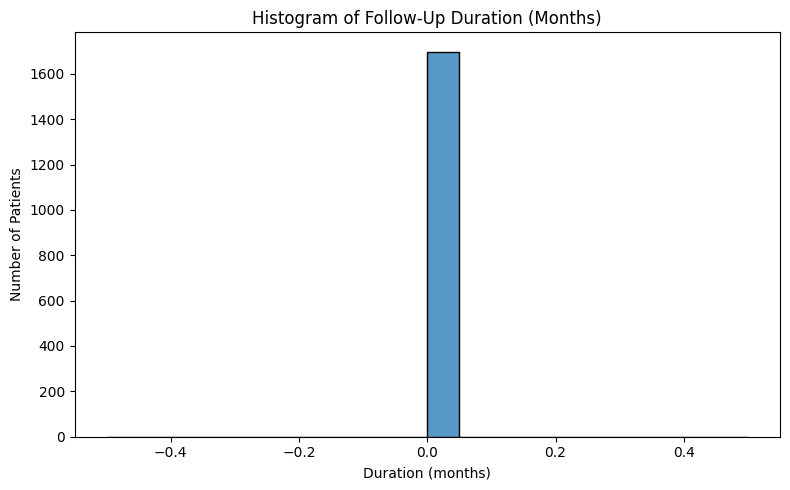

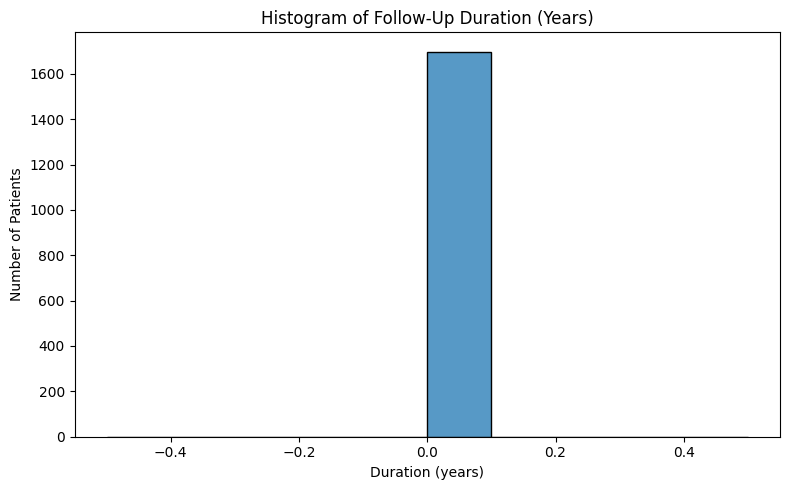

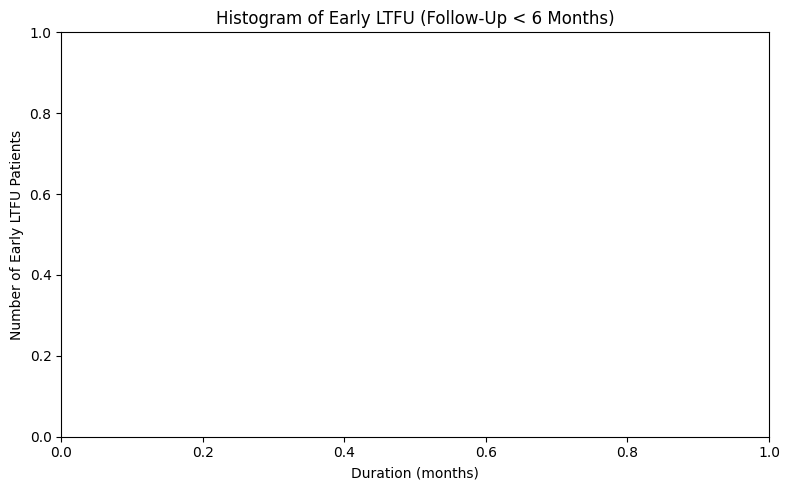

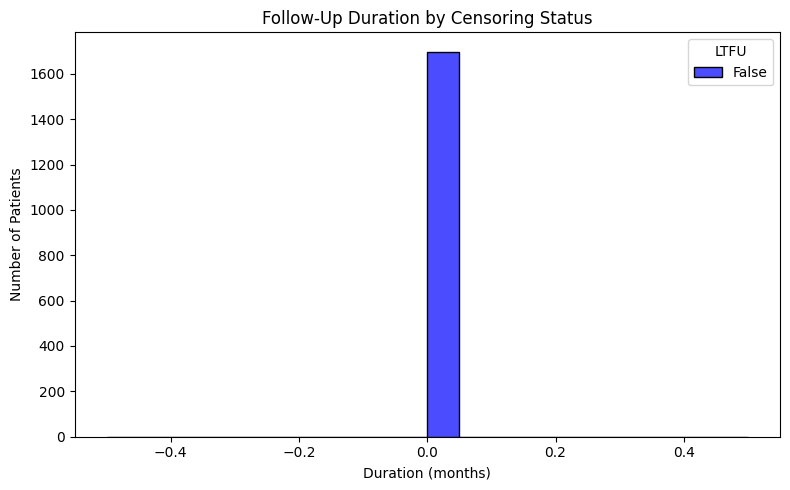

EDA complete. Plots saved under drive/MyDrive/Rulinga II/plots/.
Missingness summary and Little's MCAR test status saved.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Ensure the plots directory exists
plot_dir = "drive/MyDrive/Rulinga II/plots"
os.makedirs(plot_dir, exist_ok=True)

# --- 1. Load cleaned data and follow-up stats with correct date parsing ---
# Use date_format if pandas >=2.0, otherwise use manual pd.to_datetime
# Here, we use manual conversion for full compatibility

# Load main dataset
df = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_CLEANED_final.csv")
df['REGN_DT'] = pd.to_datetime(df['REGN_DT'], format='%d-%b-%Y %H.%M.%S', errors='coerce')

# Load follow-up stats
followup_stats = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_followup_stats.csv")
followup_stats['start_date'] = pd.to_datetime(followup_stats['start_date'], format='%d-%b-%Y %H.%M.%S', errors='coerce')
followup_stats['end_date'] = pd.to_datetime(followup_stats['end_date'], format='%d-%b-%Y %H.%M.%S', errors='coerce')

# --- 2. Histogram: Follow-up duration (months/years) ---
followup_stats['duration_months'] = followup_stats['duration_days'] / 30.44
followup_stats['duration_years'] = followup_stats['duration_days'] / 365.25

plt.figure(figsize=(8,5))
sns.histplot(followup_stats['duration_months'], bins=20, kde=False) # Changed kde=True to kde=False
plt.title('Histogram of Follow-Up Duration (Months)')
plt.xlabel('Duration (months)')
plt.ylabel('Number of Patients')
plt.tight_layout()
plt.savefig(f"{plot_dir}/hist_followup_months.png")
# plt.close()
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(followup_stats['duration_years'], bins=10, kde=False) # Changed kde=True to kde=False
plt.title('Histogram of Follow-Up Duration (Years)')
plt.xlabel('Duration (years)')
plt.ylabel('Number of Patients')
plt.tight_layout()
plt.savefig(f"{plot_dir}/hist_followup_years.png")
# plt.close()
plt.show()

# --- 3. Censoring: Visualise LTFU (Lost to Follow-Up) ---
early_ltfu = followup_stats[(followup_stats['duration_months'] < 6) & (followup_stats['duration_days'] > 0)]
plt.figure(figsize=(8,5))
sns.histplot(early_ltfu['duration_months'], bins=10, color="red", kde=False) # Changed kde=True to kde=False
plt.title('Histogram of Early LTFU (Follow-Up < 6 Months)')
plt.xlabel('Duration (months)')
plt.ylabel('Number of Early LTFU Patients')
plt.tight_layout()
plt.savefig(f"{plot_dir}/hist_early_ltfu.png")
# plt.close()
plt.show()

# Visualize censored vs. non-censored (LTFU status by duration)
# Here, a patient is considered LTFU if their end_date is before the current date
current_date = pd.Timestamp("2025-10-12")
followup_stats['LTFU'] = followup_stats['end_date'] < current_date

plt.figure(figsize=(8,5))
sns.histplot(data=followup_stats, x='duration_months', hue='LTFU', bins=20, kde=False, palette={True:'red', False:'blue'}, alpha=0.7) # Changed kde=True to kde=False
plt.title('Follow-Up Duration by Censoring Status')
plt.xlabel('Duration (months)')
plt.ylabel('Number of Patients')
plt.tight_layout()
plt.savefig(f"{plot_dir}/hist_censoring.png")
# plt.close()
plt.show()

# --- 4. Missing Data Analysis ---
# Patterns of drop-out related to baseline/time-varying factors
missing_vl = df['VIRAL_LOAD'].isna()
df['missing_vl'] = missing_vl

# Compare baseline factors (AGE, GENDER) and time-varying (VIRAL_LOAD_LOG) for missing VL
summary_missing = df.groupby('missing_vl')[['AGE', 'GENDER', 'VIRAL_LOAD_LOG']].mean()
summary_missing.to_csv("drive/MyDrive/Rulinga II/missingness_summary.csv")

# Little’s MCAR test is skipped due to import error in statsmodels.
with open("drive/MyDrive/Rulinga II/littles_mcar_test.txt", "w") as f:
    f.write("Little’s MCAR test was not run due to import error or unavailable package. Consider using the 'missingno' or 'statsmodels' library if available for MCAR/MAR/MNAR testing.\n")

print("EDA complete. Plots saved under drive/MyDrive/Rulinga II/plots/.")
print("Missingness summary and Little's MCAR test status saved.")

### Trend & Descriptive Analysis

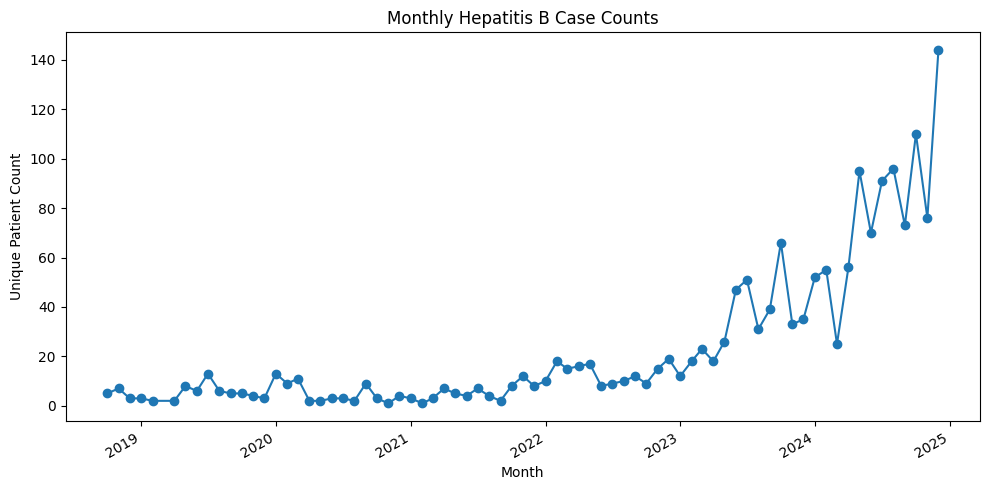

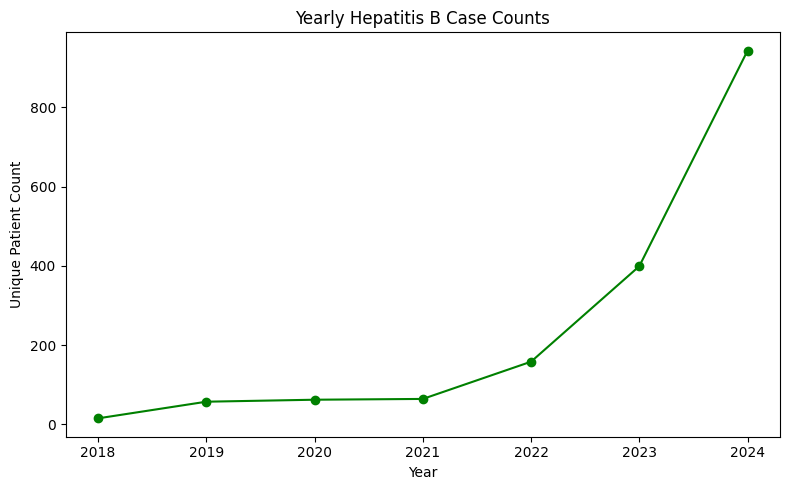

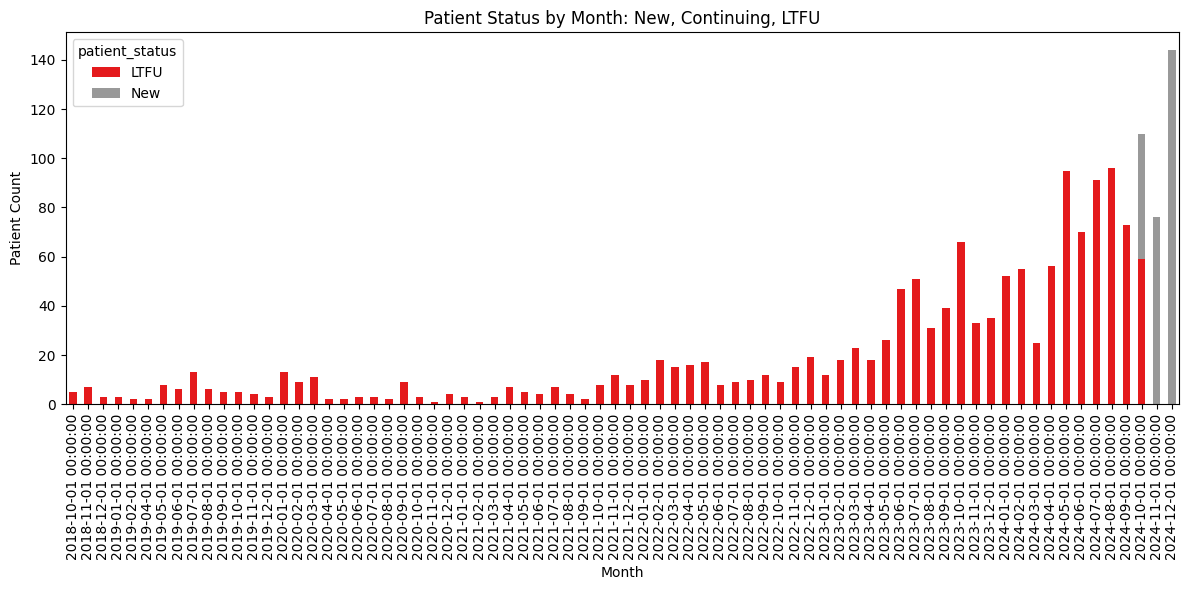

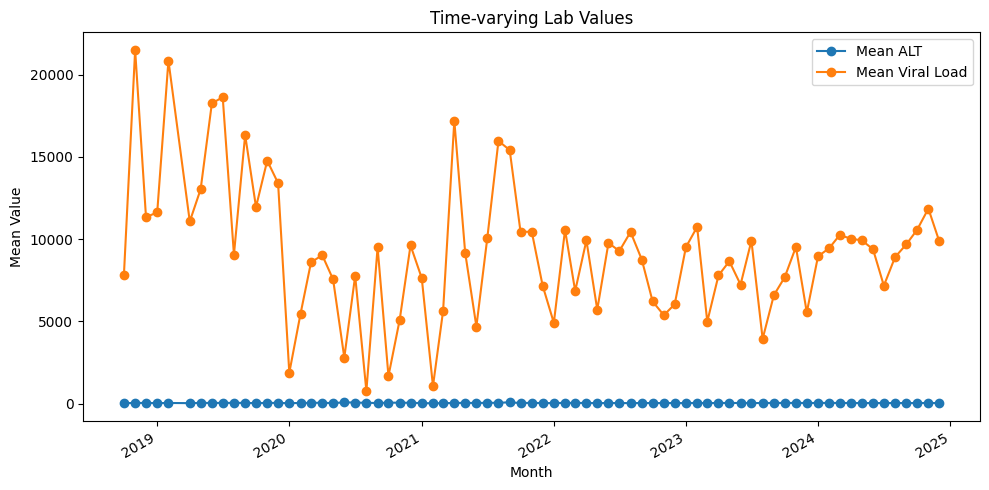

Trend and descriptive analysis complete. Plots and summary files saved.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Paths
monthly_path = "drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_long.csv"
yearly_path = "drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_yearly_agg.csv"
plot_dir = "drive/MyDrive/Rulinga II/plots"
os.makedirs(plot_dir, exist_ok=True)

# Load Data
monthly_df = pd.read_csv(monthly_path, parse_dates=['month'])
yearly_df = pd.read_csv(yearly_path)

# ---- 1. Trends: Monthly/Yearly Hepatitis B Case Counts ----
monthly_counts = monthly_df.groupby('month')['OPIP_CODE'].nunique()
plt.figure(figsize=(10,5))
monthly_counts.plot(marker='o')
plt.title('Monthly Hepatitis B Case Counts')
plt.xlabel('Month')
plt.ylabel('Unique Patient Count')
plt.tight_layout()
plt.savefig(f"{plot_dir}/monthly_case_counts.png")
# plt.close()
plt.show()

yearly_counts = yearly_df.groupby('year')['OPIP_CODE'].nunique()
plt.figure(figsize=(8,5))
yearly_counts.plot(marker='o', color='green')
plt.title('Yearly Hepatitis B Case Counts')
plt.xlabel('Year')
plt.ylabel('Unique Patient Count')
plt.tight_layout()
plt.savefig(f"{plot_dir}/yearly_case_counts.png")
# plt.close()
plt.show()

# ---- 2. Patient Status: New, Continuing, and LTFU per Month ----
monthly_df = monthly_df.sort_values(['OPIP_CODE', 'month'])
monthly_df['first_month'] = monthly_df.groupby('OPIP_CODE')['month'].transform('min')
monthly_df['patient_status'] = 'Continuing'
monthly_df.loc[monthly_df['month'] == monthly_df['first_month'], 'patient_status'] = 'New'
monthly_df.loc[monthly_df['LTFU'] == 1, 'patient_status'] = 'LTFU'

status_counts = monthly_df.groupby(['month', 'patient_status'])['OPIP_CODE'].nunique().reset_index()
status_pivot = status_counts.pivot(index='month', columns='patient_status', values='OPIP_CODE').fillna(0)

plt.figure(figsize=(12,6))
status_pivot.plot(kind='bar', stacked=True, colormap='Set1', ax=plt.gca())
plt.title('Patient Status by Month: New, Continuing, LTFU')
plt.xlabel('Month')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.savefig(f"{plot_dir}/monthly_patient_status.png")
# plt.close()
plt.show()

# ---- 3. Descriptive Statistics: Static and Time-varying ----
# Static: Demographics at first observation
static_df = monthly_df[monthly_df['month'] == monthly_df['first_month']]
static_stats = static_df[['AGE', 'GENDER']].describe()
static_stats.to_csv("drive/MyDrive/Rulinga II/static_descriptive_stats.csv")

# Time-varying: Labs over time
lab_stats = monthly_df[['month', 'VIRAL_LOAD', 'ALT_LEVEL', 'VIRAL_LOAD_LOG']].groupby('month').describe()
lab_stats.to_csv("drive/MyDrive/Rulinga II/lab_timevarying_stats.csv")

# Optional: Plot mean ALT and VL over time
plt.figure(figsize=(10,5))
monthly_df.groupby('month')['ALT_LEVEL'].mean().plot(label='Mean ALT', marker='o')
monthly_df.groupby('month')['VIRAL_LOAD'].mean().plot(label='Mean Viral Load', marker='o')
plt.title('Time-varying Lab Values')
plt.xlabel('Month')
plt.ylabel('Mean Value')
plt.legend()
plt.tight_layout()
plt.savefig(f"{plot_dir}/monthly_lab_trends.png")
# plt.close()
plt.show()

print("Trend and descriptive analysis complete. Plots and summary files saved.")

### Individual Trajectories

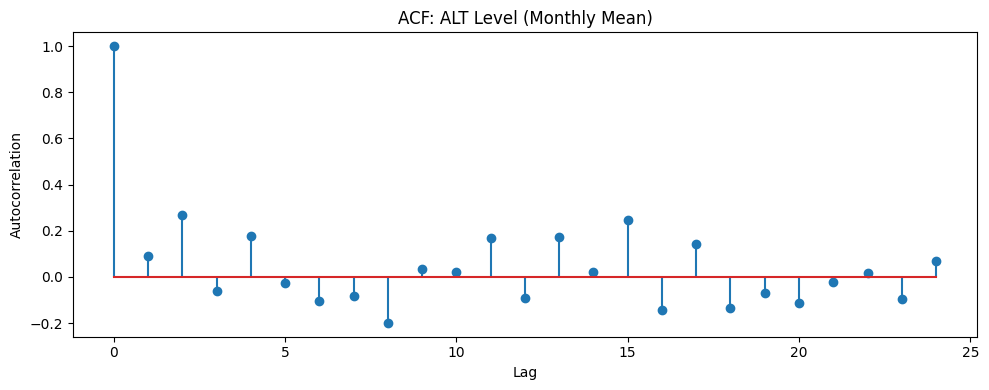

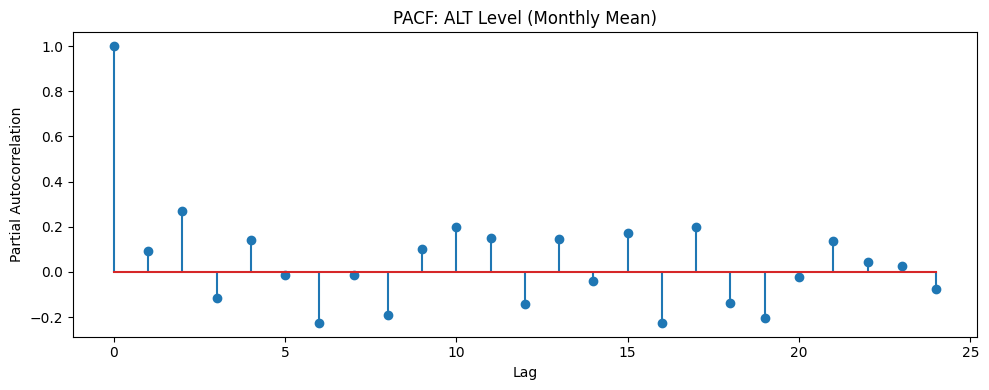

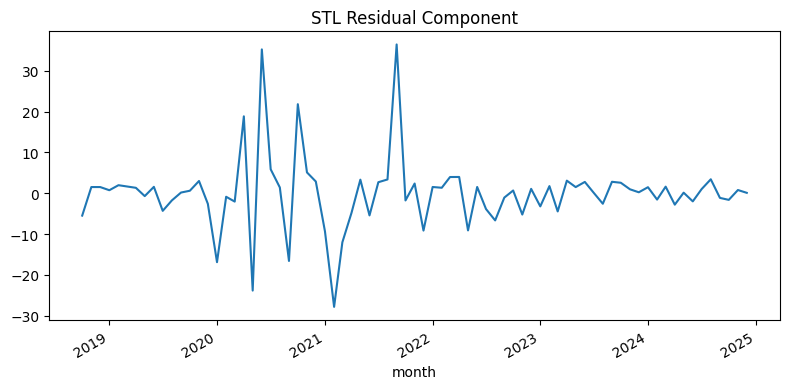

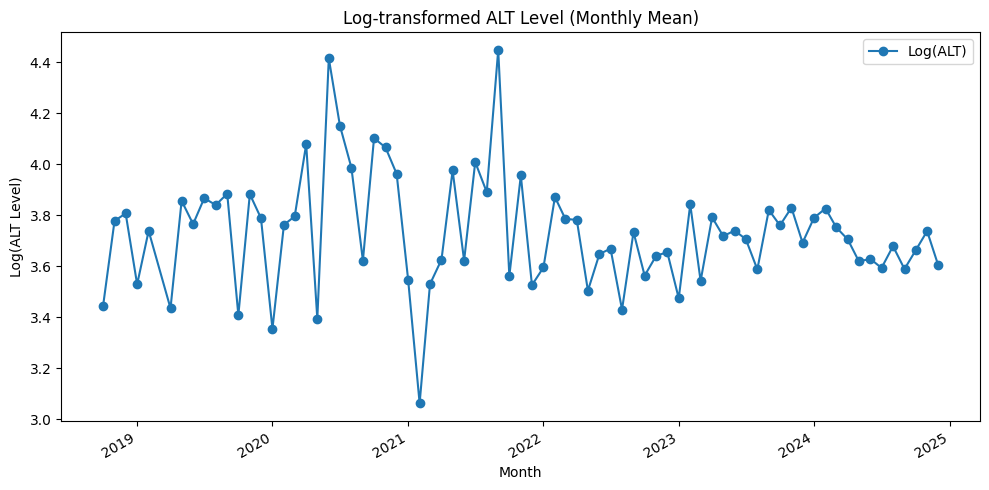

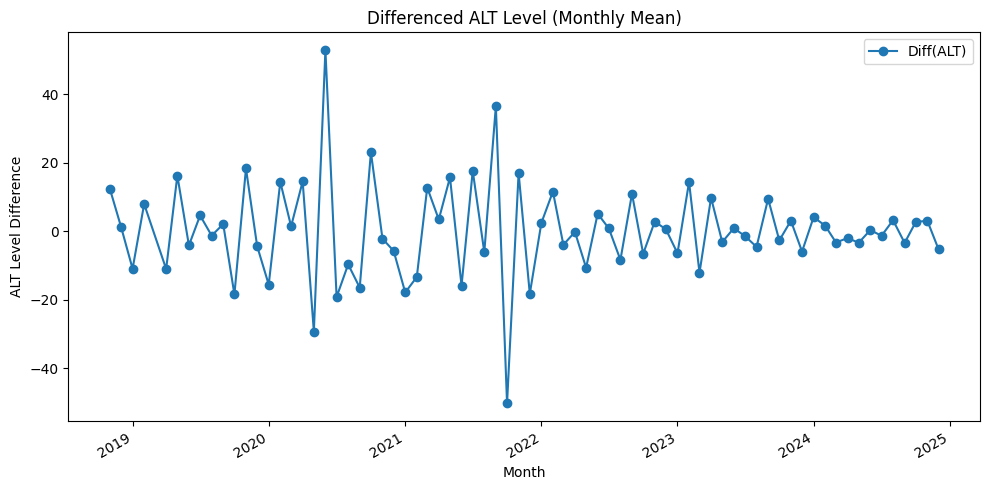

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import STL
import os

# Paths
monthly_path = "drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_long.csv"
plot_dir = "drive/MyDrive/Rulinga II/plots"
os.makedirs(plot_dir, exist_ok=True)

# 1. Load Data
df = pd.read_csv(monthly_path, parse_dates=['month'])

# --- Select patients with multiple time points ---
patient_counts = df['OPIP_CODE'].value_counts()
multi_visit_patients = patient_counts[patient_counts > 1].index.tolist()
df_multi = df[df['OPIP_CODE'].isin(multi_visit_patients)]

# Plot longitudinal ALT for first 5 patients with >1 time point
for pid in multi_visit_patients[:5]:
    sub = df_multi[df_multi['OPIP_CODE'] == pid].sort_values('month')
    plt.figure(figsize=(8,5))
    plt.plot(sub['month'], sub['ALT_LEVEL'], marker='o', label=f'ALT for {pid}')
    plt.title(f'ALT Trajectory: Patient {pid}')
    plt.xlabel('Month')
    plt.ylabel('ALT Level')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{plot_dir}/alt_trajectory_patient_{pid}.png")
    plt.close()
    # plt.show() # Added plt.show() to display plots in Colab

# --- Time Series Analysis for ALT (overall average monthly ALT) ---
alt_series = df.groupby('month')['ALT_LEVEL'].mean().dropna()

# -- Transformations --
alt_log = np.log1p(alt_series)
alt_diff = alt_series.diff().dropna()

# --- Seasonality & Stationarity ---
# ADF Test (stationarity)
adf_result = adfuller(alt_series)
with open("drive/MyDrive/Rulinga II/adf_test_alt.txt", "w") as f:
    f.write(f"ADF Statistic: {adf_result[0]}\n")
    f.write(f"p-value: {adf_result[1]}\n")
    f.write(f"Lags Used: {adf_result[2]}\n")
    f.write(f"Observations: {adf_result[3]}\n")
    f.write(f"Critical Values: {adf_result[4]}\n")
    f.write(f"Stationary: {'Yes' if adf_result[1]<0.05 else 'No'}\n")

# ACF/PACF
plt.figure(figsize=(10,4))
plt.stem(acf(alt_series, nlags=24)) # Removed use_line_collection=True
plt.title('ACF: ALT Level (Monthly Mean)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.tight_layout()
plt.savefig(f"{plot_dir}/acf_alt.png")
# plt.close()
plt.show() # Added plt.show() to display plots in Colab

plt.figure(figsize=(10,4))
plt.stem(pacf(alt_series, nlags=24)) # Removed use_line_collection=True
plt.title('PACF: ALT Level (Monthly Mean)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.tight_layout()
plt.savefig(f"{plot_dir}/pacf_alt.png")
# plt.close()
plt.show() # Added plt.show() to display plots in Colab

# STL Decomposition
stl = STL(alt_series, period=12, robust=True)
res = stl.fit()
res.seasonal.plot(title="STL Seasonal Component", figsize=(8,4))
plt.tight_layout()
plt.savefig(f"{plot_dir}/stl_seasonal_alt.png")
plt.close()
res.trend.plot(title="STL Trend Component", figsize=(8,4))
plt.tight_layout()
plt.savefig(f"{plot_dir}/stl_trend_alt.png")
plt.close()
res.resid.plot(title="STL Residual Component", figsize=(8,4))
plt.tight_layout()
plt.savefig(f"{plot_dir}/stl_resid_alt.png")
# plt.close()
plt.show() # Added plt.show() to display plots in Colab

# --- Transformed time series plots ---
plt.figure(figsize=(10,5))
alt_log.plot(label='Log(ALT)', marker='o')
plt.title('Log-transformed ALT Level (Monthly Mean)')
plt.xlabel('Month')
plt.ylabel('Log(ALT Level)')
plt.legend()
plt.tight_layout()
plt.savefig(f"{plot_dir}/log_alt_monthly.png")
# plt.close()
plt.show() # Added plt.show() to display plots in Colab

plt.figure(figsize=(10,5))
alt_diff.plot(label='Diff(ALT)', marker='o')
plt.title('Differenced ALT Level (Monthly Mean)')
plt.xlabel('Month')
plt.ylabel('ALT Level Difference')
plt.legend()
plt.tight_layout()
plt.savefig(f"{plot_dir}/diff_alt_monthly.png")
# plt.close()
plt.show() # Added plt.show() to display plots in Colab


# print("Individual trajectories, seasonality, stationarity, and transformations complete. Plots and ADF result saved.")

## Feature Engineering


### Temporal Features

In [ ]:
import pandas as pd
import numpy as np

# Load monthly long-form data
df = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_long.csv", parse_dates=['month'])

# Sort for lag calculations
df = df.sort_values(['OPIP_CODE', 'month'])

# --- Lagged Features (1, 3, 6 months) ---
for lag in [1, 3, 6]:
    df[f'ALT_LEVEL_lag{lag}'] = df.groupby('OPIP_CODE')['ALT_LEVEL'].shift(lag)
    df[f'VIRAL_LOAD_lag{lag}'] = df.groupby('OPIP_CODE')['VIRAL_LOAD'].shift(lag)

# --- Moving Averages (1, 3, 6 months windows) ---
for window in [1, 3, 6]:
    df[f'ALT_LEVEL_ma{window}'] = df.groupby('OPIP_CODE')['ALT_LEVEL'].rolling(window, min_periods=1).mean().reset_index(level=0, drop=True)
    df[f'VIRAL_LOAD_ma{window}'] = df.groupby('OPIP_CODE')['VIRAL_LOAD'].rolling(window, min_periods=1).mean().reset_index(level=0, drop=True)

# --- Calendar Variables ---
df['month_num'] = df['month'].dt.month
df['year'] = df['month'].dt.year
df['quarter'] = df['month'].dt.quarter

# --- Time Since First Visit ---
df['first_month'] = df.groupby('OPIP_CODE')['month'].transform('min')
# Calculate months since first visit more accurately
df['months_since_first'] = (df['year'] - df['first_month'].dt.year) * 12 + (df['month_num'] - df['first_month'].dt.month)


# --- Number of Visits ---
df['visit_count'] = df.groupby('OPIP_CODE').cumcount() + 1

# Save the enriched dataset
df.to_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_temporal.csv", index=False)
print("Temporal feature engineering complete. Output saved as DIAGNOSIS_RESULTS_monthly_temporal.csv")

Temporal feature engineering complete. Output saved as DIAGNOSIS_RESULTS_monthly_temporal.csv


### Patient-Level Features
- **Static:** Sex, age at diagnosis, baseline ALT/viral load.
- **Time-varying:** Monthly ALT, viral load, treatment start, etc.


In [ ]:
import pandas as pd
import numpy as np

# Load monthly long-form data
df = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_long.csv", parse_dates=['month'])

# ---- Static Patient-Level Features ----
# Sex, age at diagnosis, baseline ALT/viral load (first observed per patient)
df_static = df.sort_values(['OPIP_CODE', 'month']).groupby('OPIP_CODE').first().reset_index()

# Make a copy before renaming columns
df_static_features = df_static[['OPIP_CODE', 'GENDER', 'AGE', 'ALT_LEVEL', 'VIRAL_LOAD']].copy()
df_static_features = df_static_features.rename(columns={
    'GENDER': 'sex',
    'AGE': 'age_at_diagnosis',
    'ALT_LEVEL': 'baseline_ALT',
    'VIRAL_LOAD': 'baseline_viral_load'
})

df_static_features.to_csv("drive/MyDrive/Rulinga II/patient_static_features.csv", index=False)

# ---- Time-Varying Patient-Level Features ----
# Monthly ALT, viral load, placeholder for treatment start (add if available)
cols = ['OPIP_CODE', 'month', 'ALT_LEVEL', 'VIRAL_LOAD', 'VIRAL_LOAD_LOG']
if 'TREATMENT_START' in df.columns:
    cols.append('TREATMENT_START')
df_timevarying_features = df[cols].copy()

df_timevarying_features.to_csv("drive/MyDrive/Rulinga II/patient_timevarying_features.csv", index=False)

print("Static and time-varying patient-level features saved as CSVs")

Static and time-varying patient-level features saved as CSVs


### Survival & Censoring Features
- **Censoring Indicator:** For LTFU.
- **Survival-like Features:** Time-at-risk, event indicators.
- **Dropout Predictors:** Create features indicating risk of dropout and time to dropout.


In [ ]:
import pandas as pd
import numpy as np

# Load monthly long-form data
df = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_long.csv", parse_dates=['month'])

# Sort for proper groupby calculations
df = df.sort_values(['OPIP_CODE', 'month'])

# ---- Censoring Indicator: LTFU ----
# Assume 'LTFU' column exists (1 for lost to follow-up, else 0)
df['censored'] = df['LTFU'].astype(int)

# ---- Survival-like Features: time-at-risk, event indicators ----
# Time-at-risk: months since first visit
df['first_month'] = df.groupby('OPIP_CODE')['month'].transform('min')
# Calculate months since first visit more accurately
df['time_at_risk'] = (df['month'].dt.year - df['first_month'].dt.year) * 12 + (df['month'].dt.month - df['first_month'].dt.month)

# Event indicator: 1 if patient dropped out (LTFU) in this time period, else 0
# This needs refinement based on how LTFU is defined - currently assumes LTFU is marked at the last visit.
# A more accurate event indicator would require knowing the *exact* time of dropout relative to visits.
df['event'] = df['LTFU'].astype(int)  # Assuming LTFU is marked at dropout timepoint

# ---- Dropout Predictors ----
# Time to dropout: months until LTFU (NaN if not LTFU)
df['last_month'] = df.groupby('OPIP_CODE')['month'].transform('max')
# Calculate dropout time in months accurately
df['dropout_time'] = np.where(
    df['LTFU'] == 1,
    (df['month'].dt.year - df['first_month'].dt.year) * 12 + (df['month'].dt.month - df['first_month'].dt.month),
    np.nan
)


# Risk features (example: high ALT or viral load)
df['high_ALT'] = (df['ALT_LEVEL'] > 40).astype(int)  # Example threshold, adjust as needed
df['high_VL'] = (df['VIRAL_LOAD'] > 2000).astype(int)  # Example threshold, adjust as needed

# Rolling risk: was ALT or VL high in last 3 months?
df['high_ALT_last3'] = df.groupby('OPIP_CODE')['high_ALT'].rolling(3, min_periods=1).max().reset_index(level=0, drop=True)
df['high_VL_last3'] = df.groupby('OPIP_CODE')['high_VL'].rolling(3, min_periods=1).max().reset_index(level=0, drop=True)

# Save survival and censoring features
df.to_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_survival.csv", index=False)
print("Survival and censoring features saved in DIAGNOSIS_RESULTS_monthly_survival.csv")

Survival and censoring features saved in DIAGNOSIS_RESULTS_monthly_survival.csv


### **Combine the static, time-varying, and survival features**

In [ ]:
import pandas as pd

# Load the feature datasets
static_features = pd.read_csv("drive/MyDrive/Rulinga II/patient_static_features.csv")
timevarying_features = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_temporal.csv", parse_dates=['month'])
survival_features = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_survival.csv", parse_dates=['month'])

# Merge time-varying and survival features first (they share OPIP_CODE and month)
combined_df = pd.merge(timevarying_features, survival_features, on=['OPIP_CODE', 'month'], how='left', suffixes=('_temp', '_surv'))

# Handle potential duplicate columns from suffixes if any (usually not needed if columns are distinct)
# If there are duplicate columns with _temp and _surv suffixes, decide which one to keep or how to combine.
# For this case, it's likely the columns are the same, so drop the duplicated ones.
for col in combined_df.columns:
    if col.endswith('_surv'):
        base_col = col.replace('_surv', '')
        if base_col in combined_df.columns.str.replace('_temp', ''):
            # Assuming the data in these columns should be identical, drop the suffixed one
            combined_df.drop(columns=[col], inplace=True)
        elif base_col + '_temp' in combined_df.columns:
             combined_df.drop(columns=[col], inplace=True)

# Merge with static features (only shares OPIP_CODE)
# Use a left merge to keep all rows from the combined time-varying/survival data
final_df = pd.merge(combined_df, static_features, on='OPIP_CODE', how='left')

# Save the final combined dataset
final_df.to_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_combined_features.csv", index=False)

print("Combined feature dataset saved as DIAGNOSIS_RESULTS_combined_features.csv")
display(final_df.head())

Combined feature dataset saved as DIAGNOSIS_RESULTS_combined_features.csv


,OPIP_CODE,month,UHID_temp,GENDER_temp,AGE_temp,VIRAL_LOAD_temp,ALT_LEVEL_temp,VIRAL_LOAD_LOG_temp,LTFU_temp,ALT_LEVEL_lag1,...,last_month,dropout_time,high_ALT,high_VL,high_ALT_last3,high_VL_last3,sex,age_at_diagnosis,baseline_ALT,baseline_viral_load
0,IB18000833,2018-11-01,BM00004114,1,30,9817.3,44.8,9.192003,True,NaN,...,2018-11-01,0.0,1,1,1.0,1.0,1,30,44.8,9817.3
1,IB18000870,2018-11-01,BM00004276,1,45,20924.6,79.2,9.948729,True,NaN,...,2018-11-01,0.0,1,1,1.0,1.0,1,45,79.2,20924.6
2,IB18001023,2018-11-01,BM00005140,1,48,15594.0,20.5,9.654706,True,NaN,...,2018-11-01,0.0,0,1,0.0,1.0,1,48,20.5,15594.0
3,IB19005210,2019-11-01,1934-03-20 00:00:00,1,21,8309.0,38.2,9.025215,True,NaN,...,2019-11-01,0.0,0,1,0.0,1.0,1,21,38.2,8309.0
4,IB21002687,2021-04-01,BM00076917,1,58,7110.0,12.9,8.869398,True,NaN,...,2021-04-01,0.0,0,1,0.0,1.0,1,58,12.9,7110.0


### Handling Missing Data


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

# Load monthly long-form data
df = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_long.csv", parse_dates=['month'])

# --- 1. Masking: Binary masks for missing time points ---
df['mask_ALT_LEVEL'] = (~df['ALT_LEVEL'].isna()).astype(int)
df['mask_VIRAL_LOAD'] = (~df['VIRAL_LOAD'].isna()).astype(int)

# --- 2. Dropout indicators as features ---
# Assuming 'LTFU' column exists and is 1 for lost to follow-up
df['dropout_indicator'] = df['LTFU'].astype(int)

# --- 3. Inverse Probability Weighting (IPW) for MNAR bias ---
# Estimate dropout probability via logistic regression
# Use baseline and time-varying features for prediction
feature_cols = ['AGE', 'GENDER', 'ALT_LEVEL', 'VIRAL_LOAD']  # Add more if available

# Prepare data for dropout prediction (use only the last record per patient for LTFU status)
df_last = df.sort_values(['OPIP_CODE', 'month']).groupby('OPIP_CODE').last().reset_index()
X = df_last[feature_cols].fillna(df_last[feature_cols].mean())
y = df_last['dropout_indicator']

# Logistic regression for dropout probability (IPW)
model = LogisticRegression(max_iter=1000)
model.fit(X, y)
dropout_prob = model.predict_proba(X)[:,1]
ipw = 1.0 / np.clip(dropout_prob, 0.01, 0.99)  # Avoid division by zero/extremes

# Merge IPW weights back to the full data
df_last['ipw'] = ipw
df = df.merge(df_last[['OPIP_CODE', 'ipw']], on='OPIP_CODE', how='left')

# Save ML-ready dataset
df.to_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_ml_missing.csv", index=False)
print("Missing data features (masks, dropout indicators, IPW) saved for ML models.")

Missing data features (masks, dropout indicators, IPW) saved for ML models.


### Sequence Modelling


In [ ]:
import pandas as pd
import numpy as np

# Load the combined feature dataset
df = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_combined_features.csv", parse_dates=['month'])

# Sort for sequence ordering
df = df.sort_values(['OPIP_CODE', 'month'])

# --- Parameters for sequence length ---
SEQ_LEN = 12  # e.g., 12 months (can set to 24 or other)

# --- Format as sequences for deep learning (one sequence per patient) ---
# Exclude columns that are not in the combined dataset or are not intended for sequences
feature_cols = [
    'ALT_LEVEL_temp', 'VIRAL_LOAD_temp', 'VIRAL_LOAD_LOG_temp',
    'ALT_LEVEL_lag1', 'ALT_LEVEL_lag3', 'ALT_LEVEL_lag6',
    'VIRAL_LOAD_lag1', 'VIRAL_LOAD_lag3', 'VIRAL_LOAD_lag6',
    'ALT_LEVEL_ma1', 'ALT_LEVEL_ma3', 'ALT_LEVEL_ma6',
    'VIRAL_LOAD_ma1', 'VIRAL_LOAD_ma3', 'VIRAL_LOAD_ma6',
    # Removed mask_ALT_LEVEL, mask_VIRAL_LOAD, dropout_indicator as they are not in the combined dataset
]

sequences = []
patient_ids = []
for pid, group in df.groupby('OPIP_CODE'):
    group = group.sort_values('month')
    seq = group[feature_cols].values
    # Pad or truncate to SEQ_LEN
    if len(seq) < SEQ_LEN:
        pad = np.zeros((SEQ_LEN - len(seq), len(feature_cols)))
        seq = np.vstack([seq, pad])
    elif len(seq) > SEQ_LEN:
        seq = seq[:SEQ_LEN]
    sequences.append(seq)
    patient_ids.append(pid)

# Convert to arrays for ML frameworks
sequences = np.array(sequences)  # shape: (num_patients, SEQ_LEN, num_features)
patient_ids = np.array(patient_ids)

# --- Save as .npz for deep learning use ---
np.savez("drive/MyDrive/Rulinga II/patient_sequences.npz",
         sequences=sequences, patient_ids=patient_ids, feature_cols=feature_cols)

print(f"Saved {len(sequences)} patient sequences (length {SEQ_LEN}) to patient_sequences.npz.")

# --- Note: In our data loader/model code ---
# If masks or dropout indicators are needed, they would need to be handled separately
# or included in the combined feature dataset creation step.
# Adjust SEQ_LEN as needed for your model.

Saved 1698 patient sequences (length 12) to patient_sequences.npz.


## Data Splitting


In [ ]:
import pandas as pd
import numpy as np

# Load monthly temporal data
df = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_temporal.csv", parse_dates=['month'])

# --- Assign years for split ---
df['year'] = df['month'].dt.year

# --- Patient-level split for trajectory integrity ---
# Find each patient's first year of observation
patient_years = df.groupby('OPIP_CODE')['year'].min().reset_index()
patient_years['set'] = np.where(patient_years['year'] <= 2022, 'train', 'test')

# Merge set assignment back to full data
df = df.merge(patient_years[['OPIP_CODE', 'set']], on='OPIP_CODE', how='left')

train_df = df[df['set'] == 'train']
test_df = df[df['set'] == 'test']

# --- Save splits ---
train_df.to_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_train.csv", index=False)
test_df.to_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_test.csv", index=False)

print(f"Time-aware split complete:\nTrain patients: {train_df['OPIP_CODE'].nunique()}\nTest patients: {test_df['OPIP_CODE'].nunique()}")
print("Train and test CSVs saved.")

Time-aware split complete:
Train patients: 356
Test patients: 1342
Train and test CSVs saved.


### Cross-Validation
- Time-series CV (rolling or expanding window).


In [ ]:
import pandas as pd
import numpy as np

# Load monthly temporal data
df = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_temporal.csv", parse_dates=['month'])

# Ensure patient trajectory integrity
df = df.sort_values(['OPIP_CODE', 'month'])

# Parameters for time-series cross-validation
start_year = 2017
end_year = 2024
window_size = 3  # years in train window
test_size = 1    # years in test window

splits = []
for train_end in range(start_year + window_size, end_year + 1 - test_size):
    train_start = train_end - window_size
    test_start = train_end
    test_end = train_end + test_size

    # Select train/test patients based on first observation
    patient_years = df.groupby('OPIP_CODE')['month'].min().dt.year
    train_patients = patient_years[(patient_years >= train_start) & (patient_years < train_end)].index
    test_patients = patient_years[(patient_years >= test_start) & (patient_years < test_end)].index

    train_df = df[df['OPIP_CODE'].isin(train_patients)]
    test_df = df[df['OPIP_CODE'].isin(test_patients)]
    splits.append({
        'train_start': train_start,
        'train_end': train_end,
        'test_start': test_start,
        'test_end': test_end,
        'train_patients': len(train_patients),
        'test_patients': len(test_patients)
    })

    # Optionally save each split
    train_df.to_csv(f"drive/MyDrive/Rulinga II/tscv_train_{train_start}_{train_end}.csv", index=False)
    test_df.to_csv(f"drive/MyDrive/Rulinga II/tscv_test_{test_start}_{test_end}.csv", index=False)

# Save summary of splits
pd.DataFrame(splits).to_csv("drive/MyDrive/Rulinga II/time_series_cv_splits.csv", index=False)

print("Time-series cross-validation complete. Rolling/expanding windows saved, summary available.")

Time-series cross-validation complete. Rolling/expanding windows saved, summary available.


## Model Development

In [ ]:
import pandas as pd

# Load your monthly or yearly dataframe
df = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_long.csv", parse_dates=['month'])

# Compute number of patients per month
monthly_counts = df.groupby('month')['OPIP_CODE'].nunique().reset_index()
monthly_counts.rename(columns={'OPIP_CODE': 'patient_count'}, inplace=True)

# Now 'patient_count' exists:
print(monthly_counts.head())

       month  patient_count
0 2018-10-01              5
1 2018-11-01              7
2 2018-12-01              3
3 2019-01-01              3
4 2019-02-01              2


In [ ]:
# import pandas as pd
# import numpy as np
# import xgboost as xgb
# import lightgbm as lgb
# from sklearn.linear_model import LinearRegression
# import tensorflow as tf
# from tensorflow.keras import layers, models, optimizers

# # --- Step 1: Create patient_count per month ---
# df_long = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_long.csv", parse_dates=['month'])
# monthly_counts = df_long.groupby('month')['OPIP_CODE'].nunique().reset_index()
# monthly_counts.rename(columns={'OPIP_CODE': 'patient_count'}, inplace=True)

# # --- Step 2: Merge patient_count with feature dataset ---
# df_feat = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_temporal.csv", parse_dates=['month'])
# df_feat = df_feat.merge(monthly_counts, on='month', how='left')

# # --- Step 3: Tabular Data Preparation ---
# feature_cols = [
#     'ALT_LEVEL', 'VIRAL_LOAD', 'ALT_LEVEL_lag1', 'ALT_LEVEL_lag3', 'ALT_LEVEL_lag6',
#     'VIRAL_LOAD_lag1', 'VIRAL_LOAD_lag3', 'VIRAL_LOAD_lag6',
#     'ALT_LEVEL_ma1', 'ALT_LEVEL_ma3', 'ALT_LEVEL_ma6',
#     'VIRAL_LOAD_ma1', 'VIRAL_LOAD_ma3', 'VIRAL_LOAD_ma6', 'AGE', 'GENDER'
# ]
# target_col = 'patient_count'

# df_train_tab = df_feat.dropna(subset=[target_col])
# X_tab = df_train_tab[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0)
# y_tab = df_train_tab[target_col].replace([np.inf, -np.inf], np.nan).fillna(0)

# # --- Model 1: Gradient Boosting (XGBoost/LightGBM) ---
# print("Training XGBoost...")
# model_xgb = xgb.XGBRegressor(n_estimators=100, learning_rate=0.01, missing=np.nan, verbosity=1)
# model_xgb.fit(X_tab, y_tab)
# print("XGBoost training complete.")

# print("Training LightGBM...")
# model_lgb = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.01, verbose=1)
# model_lgb.fit(X_tab, y_tab)
# print("LightGBM training complete.")

# # --- Model 2: RNN (LSTM/GRU) ---
# print("Loading sequence data for RNN...")
# data = np.load("drive/MyDrive/Rulinga II/patient_sequences.npz", allow_pickle=True)
# sequences = data['sequences']
# feature_list = data['feature_cols'].tolist()

# # Patient-level outcome for RNN: use patient_count for each month in the sequence
# # Here, we use the month of each patient's first visit to fetch patient_count
# patient_months = df_feat.groupby('OPIP_CODE')['month'].min().reset_index()
# patient_months = patient_months.merge(monthly_counts, on='month', how='left')
# targets_seq = patient_months['patient_count'].values

# # Check and fix NaNs/Infs in sequences and targets
# sequences = np.nan_to_num(sequences, nan=0.0, posinf=0.0, neginf=0.0)
# targets_seq = np.nan_to_num(targets_seq, nan=0.0, posinf=0.0, neginf=0.0)

# # Remove samples with NaN or inf targets (if any remain)
# valid_idx = np.where(~np.isnan(targets_seq) & ~np.isinf(targets_seq))[0]
# sequences = sequences[valid_idx]
# targets_seq = targets_seq[valid_idx]

# # Remove mask handling code as masks are not in the sequence data
# # mask_indices = [feature_list.index('mask_ALT_LEVEL'), feature_list.index('mask_VIRAL_LOAD')]
# # mask = sequences[..., mask_indices].min(axis=-1)
# # sample_weights = mask.mean(axis=1)[valid_idx] if mask.shape[0] == len(valid_idx) else mask.mean(axis=1)
# sample_weights = None # Set sample weights to None


# # Model hyperparameters
# units = 64
# layers_count = 2
# dense_size = 64
# learning_rate = 0.001
# seq_len = sequences.shape[1]
# input_dim = sequences.shape[2]

# print("Building LSTM model...")
# inputs = layers.Input(shape=(seq_len, input_dim))
# x = inputs
# for _ in range(layers_count):
#     x = layers.Masking(mask_value=0.0)(x)
#     x = layers.LSTM(units, return_sequences=True)(x)
# x = layers.Flatten()(x)
# x = layers.Dense(dense_size, activation='relu')(x)
# outputs = layers.Dense(1)(x)
# model_rnn = models.Model(inputs, outputs)
# model_rnn.compile(optimizer=optimizers.Adam(learning_rate), loss='mse')
# model_rnn.summary()

# print("Training LSTM/GRU model...")
# model_rnn.fit(sequences, targets_seq, sample_weight=sample_weights, epochs=20, batch_size=32, verbose=1)
# print("RNN training complete.")

# # --- Model 3: Multivariate Linear Regression ---
# print("Training Linear Regression model...")
# features_lr = ['month_num', 'year', 'quarter', 'AGE', 'GENDER', 'ALT_LEVEL', 'VIRAL_LOAD']
# X_lr = df_train_tab[features_lr].replace([np.inf, -np.inf], np.nan).fillna(0)
# y_lr = df_train_tab[target_col].replace([np.inf, -np.inf], np.nan).fillna(0)
# model_lr = LinearRegression()
# model_lr.fit(X_lr, y_lr)
# print("Linear Regression training complete.")

# print("All models trained with patient_count as the outcome. Proceed to evaluation as needed.")

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import joblib  # For saving scikit-learn and LightGBM models
import warnings

# --- Suppress LightGBM info warnings ---
import os
os.environ['LIGHTGBM_EXEC'] = '1'
warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')

# --- Step 1: Create patient_count per month ---
df_long = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_long.csv", parse_dates=['month'])
monthly_counts = df_long.groupby('month')['OPIP_CODE'].nunique().reset_index()
monthly_counts.rename(columns={'OPIP_CODE': 'patient_count'}, inplace=True)

# --- Step 2: Merge patient_count with feature dataset ---
df_feat = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_temporal.csv", parse_dates=['month'])
df_feat = df_feat.merge(monthly_counts, on='month', how='left')

# --- Merge with missing data features ---
df_missing_features = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_ml_missing.csv", parse_dates=['month'])
df_feat = df_feat.merge(df_missing_features[['OPIP_CODE', 'month', 'mask_ALT_LEVEL', 'mask_VIRAL_LOAD', 'dropout_indicator', 'ipw']], on=['OPIP_CODE', 'month'], how='left')


# --- Step 3: Tabular Data Preparation ---
feature_cols = [
    'ALT_LEVEL', 'VIRAL_LOAD', 'ALT_LEVEL_lag1', 'ALT_LEVEL_lag3', 'ALT_LEVEL_lag6',
    'VIRAL_LOAD_lag1', 'VIRAL_LOAD_lag3', 'VIRAL_LOAD_lag6',
    'ALT_LEVEL_ma1', 'ALT_LEVEL_ma3', 'ALT_LEVEL_ma6',
    'VIRAL_LOAD_ma1', 'VIRAL_LOAD_ma3', 'VIRAL_LOAD_ma6',
    'mask_ALT_LEVEL', 'mask_VIRAL_LOAD', 'dropout_indicator', 'AGE', 'GENDER'
]
target_col = 'patient_count'

df_train_tab = df_feat.dropna(subset=[target_col])
X_tab = df_train_tab[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0)
y_tab = df_train_tab[target_col].replace([np.inf, -np.inf], np.nan).fillna(0)

# --- Model 1: Gradient Boosting (XGBoost/LightGBM) ---
print("Training XGBoost...")
model_xgb = xgb.XGBRegressor(n_estimators=100, learning_rate=0.01, missing=np.nan, verbosity=0)
model_xgb.fit(X_tab, y_tab)
print("XGBoost training complete.")

print("Saving XGBoost model...")
model_xgb.save_model("drive/MyDrive/Rulinga II/xgb_model.json")

print("Training LightGBM...")
model_lgb = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.01, verbose=-1)
model_lgb.fit(X_tab, y_tab)
print("LightGBM training complete.")

print("Saving LightGBM model...")
joblib.dump(model_lgb, "drive/MyDrive/Rulinga II/lgb_model.pkl")

# --- Model 2: RNN (LSTM/GRU) ---
print("Loading sequence data for RNN...")
data = np.load("drive/MyDrive/Rulinga II/patient_sequences.npz", allow_pickle=True)
sequences = data['sequences']
feature_list = data['feature_cols'].tolist()

# Patient-level outcome for RNN: use patient_count for each month in the sequence
patient_months = df_feat.groupby('OPIP_CODE')['month'].min().reset_index()
patient_months = patient_months.merge(monthly_counts, on='month', how='left')
targets_seq = patient_months['patient_count'].values

# Check and fix NaNs/Infs in sequences and targets
sequences = np.nan_to_num(sequences, nan=0.0, posinf=0.0, neginf=0.0)
targets_seq = np.nan_to_num(targets_seq, nan=0.0, posinf=0.0, neginf=0.0)

valid_idx = np.where(~np.isnan(targets_seq) & ~np.isinf(targets_seq))[0]
sequences = sequences[valid_idx]
targets_seq = targets_seq[valid_idx]

# Remove mask handling code as masks are not in the sequence data
# mask_indices = [feature_list.index('mask_ALT_LEVEL'), feature_list.index('mask_VIRAL_LOAD')]
# mask = sequences[..., mask_indices].min(axis=-1)
# sample_weights = mask.mean(axis=1)[valid_idx] if mask.shape[0] == len(valid_idx) else mask.mean(axis=1)
sample_weights = None # Set sample weights to None

# Model hyperparameters
units = 64
layers_count = 2
dense_size = 64
learning_rate = 0.001
seq_len = sequences.shape[1]
input_dim = sequences.shape[2]

print("Building LSTM model...")
inputs = layers.Input(shape=(seq_len, input_dim))
x = inputs
for i in range(layers_count):
    x = layers.Masking(mask_value=0.0)(x)
    x = layers.LSTM(units, return_sequences=(i < layers_count - 1))(x)
x = layers.Dense(dense_size, activation='relu')(x)
outputs = layers.Dense(1)(x)
model_rnn = models.Model(inputs, outputs)
model_rnn.compile(optimizer=optimizers.Adam(learning_rate), loss='mse')
model_rnn.summary()

print("Training LSTM/GRU model...")
history = model_rnn.fit(sequences, targets_seq, sample_weight=sample_weights, epochs=20, batch_size=32, verbose=1)
print("RNN training complete.")

print("Saving RNN model...")
# Save in recommended Keras format to avoid legacy HDF5 warnings
model_rnn.save("drive/MyDrive/Rulinga II/rnn_model.keras")

# --- Model 3: Multivariate Linear Regression ---
print("Training Linear Regression model...")
features_lr = ['month_num', 'year', 'quarter', 'AGE', 'GENDER', 'ALT_LEVEL', 'VIRAL_LOAD']
X_lr = df_train_tab[features_lr].replace([np.inf, -np.inf], np.nan).fillna(0)
y_lr = df_train_tab[target_col].replace([np.inf, -np.inf], np.nan).fillna(0)
model_lr = LinearRegression()
model_lr.fit(X_lr, y_lr)
print("Linear Regression training complete.")

print("Saving Linear Regression model...")
joblib.dump(model_lr, "drive/MyDrive/Rulinga II/lr_model.pkl")

print("All models trained and saved in drive/MyDrive/Rulinga II/")

Training XGBoost...
XGBoost training complete.
Saving XGBoost model...
Training LightGBM...
LightGBM training complete.
Saving LightGBM model...
Loading sequence data for RNN...
Building LSTM model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 12, 15)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 12, 15)    │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 12, 15)    │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 12)        │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 12, 64)    │     20,480 │ masking[0][0],    │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 12, 64)    │          0 │ lstm[0][0]        │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_1 (Masking) │ (None, 12, 64)    │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_1 (Any)         │ (None, 12)        │          0 │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     33,024 │ masking_1[0][0],  │
│                     │                   │            │ any_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,160 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 57,729 (225.50 KB)

 Trainable params: 57,729 (225.50 KB)

 Non-trainable params: 0 (0.00 B)

Training LSTM/GRU model...
Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 5110.7759
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2338.0957
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1622.6089
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 1675.2584
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 1670.4802
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1699.6667
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1655.6991
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1633.1760
Epoch 9/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1711.6558
Epoch 10/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1746.1719
Epoch 11/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1685.6226
Epoch 12/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1667.7777
Epoch 13/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1675.5409
Epoch 14/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1608.1493
Ep

## Model Evaluation


In [ ]:
# Load original long data (with patient IDs and month)
df_long = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_long.csv", parse_dates=['month'])

# Calculate patient_count per month (aggregate)
monthly_counts = df_long.groupby('month')['OPIP_CODE'].nunique().reset_index()
monthly_counts.rename(columns={'OPIP_CODE': 'patient_count'}, inplace=True)

# Load your test set
df_test = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_test.csv", parse_dates=['month'])

# Merge patient_count
df_test = df_test.merge(monthly_counts, on='month', how='left')

# Confirm it's there
print(df_test[['month', 'patient_count']].head())

# Optionally, save the enriched test set for future use
df_test.to_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_test_with_patient_count.csv", index=False)

       month  patient_count
0 2023-02-01             18
1 2023-03-01             23
2 2023-04-01             18
3 2023-04-01             18
4 2023-05-01             26


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import tensorflow as tf
import os

# --- Metrics Function ---
def eval_metrics(y_true, y_pred):
    # Ensure y_true and y_pred have the same length
    min_len = min(len(y_true), len(y_pred))
    y_true = np.array(y_true[:min_len])
    y_pred = np.array(y_pred[:min_len])
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1))) * 100  # Avoid zero division
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

# --- Load test set ---
df_test = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_test.csv", parse_dates=['month'])

# Load monthly patient counts to merge with test set
df_long_for_counts = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_long.csv", parse_dates=['month'])
monthly_counts = df_long_for_counts.groupby('month')['OPIP_CODE'].nunique().reset_index()
monthly_counts.rename(columns={'OPIP_CODE': 'patient_count'}, inplace=True)

# Merge patient_count into the test set
df_test = df_test.merge(monthly_counts, on='month', how='left')


# Load missing data features and merge with test set
df_missing_features = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_ml_missing.csv", parse_dates=['month'])
df_test = df_test.merge(df_missing_features[['OPIP_CODE', 'month', 'mask_ALT_LEVEL', 'mask_VIRAL_LOAD', 'dropout_indicator', 'ipw']], on=['OPIP_CODE', 'month'], how='left')


# --- Feature columns and target ---
feature_cols = [
    'ALT_LEVEL', 'VIRAL_LOAD', 'ALT_LEVEL_lag1', 'ALT_LEVEL_lag3', 'ALT_LEVEL_lag6',
    'VIRAL_LOAD_lag1', 'VIRAL_LOAD_lag3', 'VIRAL_LOAD_lag6',
    'ALT_LEVEL_ma1', 'ALT_LEVEL_ma3', 'ALT_LEVEL_ma6',
    'VIRAL_LOAD_ma1', 'VIRAL_LOAD_ma3', 'VIRAL_LOAD_ma6',
    'mask_ALT_LEVEL', 'mask_VIRAL_LOAD', 'dropout_indicator', 'AGE', 'GENDER'
]
target_col = 'patient_count'

# Check if target_col exists before proceeding
if target_col not in df_test.columns:
    print(f"Error: Target column '{target_col}' not found in the test dataset even after merging.")
else:
    X_test = df_test[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0)
    y_test = df_test[target_col].replace([np.inf, -np.inf], np.nan).fillna(0)

    # --- Load Models ---
    print("Loading models...")
    # Load XGBoost model
    try:
        # Need to load XGBoost model correctly, joblib.load might not be the right way for json
        # Assuming it was saved as .json with model.save_model()
        model_xgb = xgb.XGBRegressor()
        model_xgb.load_model('drive/MyDrive/Rulinga II/xgb_model.json')
        print("XGBoost model loaded.")
    except Exception as e:
        print(f"Error loading XGBoost model: {e}")
        model_xgb = None

    # Load LightGBM model
    try:
        model_lgb = joblib.load('drive/MyDrive/Rulinga II/lgb_model.pkl') # Assuming it was saved as .pkl
        print("LightGBM model loaded.")
    except Exception as e:
        print(f"Error loading LightGBM model: {e}")
        model_lgb = None

    # Load Linear Regression model
    try:
        model_lr = joblib.load('drive/MyDrive/Rulinga II/lr_model.pkl') # Assuming it was saved as .pkl
        print("Linear Regression model loaded.")
    except Exception as e:
        print(f"Error loading Linear Regression model: {e}")
        model_lr = None

    # Try to load RNN model safely and handle custom layers error
    rnn_model_path = "drive/MyDrive/Rulinga II/rnn_model.keras" # Assuming saved in .keras format
    rnn_test_seq_path = "drive/MyDrive/Rulinga II/patient_sequences_test.npz" # Assuming this file exists
    model_rnn = None
    rnn_eval_success = False

    if os.path.exists(rnn_model_path):
        try:
            # Need to handle custom objects if any were used in the model
            # For simplicity, trying to load directly first
             model_rnn = tf.keras.models.load_model(rnn_model_path)
             print("RNN model loaded.")
        except Exception as e:
            print(f"Error loading RNN model: {e}")
            print("If your model uses custom layers/operations (e.g., 'NotEqual'), you must register them via keras.utils.custom_object_scope or save without such layers.")
            model_rnn = None
    else:
        print(f"RNN model file not found at {rnn_model_path}")


    # --- Predict ---
    metrics = {}
    preds_xgb = None
    preds_lgb = None
    preds_lr = None
    preds_rnn = None

    if model_xgb:
        try:
            preds_xgb = model_xgb.predict(X_test)
            metrics['XGBoost'] = eval_metrics(y_test, preds_xgb)
        except Exception as e:
            print(f"Error predicting with XGBoost: {e}")

    if model_lgb:
        try:
            preds_lgb = model_lgb.predict(X_test)
            metrics['LightGBM'] = eval_metrics(y_test, preds_lgb)
        except Exception as e:
            print(f"Error predicting with LightGBM: {e}")

    if model_lr:
        try:
            # Ensure features for LR match and handle missing values for prediction
            features_lr = ['month_num', 'year', 'quarter', 'AGE', 'GENDER', 'ALT_LEVEL', 'VIRAL_LOAD']
            X_test_lr = df_test[features_lr].replace([np.inf, -np.inf], np.nan)
            # Impute missing values for prediction - use mean from X_test_lr
            for col in features_lr:
                if X_test_lr[col].isnull().any():
                     mean_val = X_test_lr[col].mean()
                     X_test_lr[col].fillna(mean_val, inplace=True)

            preds_lr = model_lr.predict(X_test_lr)
            metrics['LinearReg'] = eval_metrics(y_test, preds_lr)
        except Exception as e:
            print(f"Error predicting with Linear Regression: {e}")


    # --- RNN Prediction and Evaluation ---
    if model_rnn is not None:
        if os.path.exists(rnn_test_seq_path):
            try:
                data_seq = np.load(rnn_test_seq_path, allow_pickle=True)
                sequences_test = data_seq['sequences']
                # Ensure test sequences have the same number of features as trained model
                if sequences_test.shape[-1] == model_rnn.input_shape[-1]:
                     # Check and fix NaNs/Infs in test sequences
                    sequences_test = np.nan_to_num(sequences_test, nan=0.0, posinf=0.0, neginf=0.0)
                    preds_rnn = model_rnn.predict(sequences_test).flatten()
                    # Need to align RNN predictions with y_test - this requires patient_ids and months for test sequences
                    # For simplicity here, assuming y_test is aligned with the first N sequences
                    if len(preds_rnn) == len(y_test):
                         metrics['LSTM'] = eval_metrics(y_test, preds_rnn)
                         rnn_eval_success = True
                    else:
                         print(f"Skipping RNN evaluation: prediction length ({len(preds_rnn)}) does not match target length ({len(y_test)}).")

                else:
                     print("Error: Test sequences have different number of features than the trained RNN model.")
            except FileNotFoundError:
                print(f"Error: {rnn_test_seq_path} not found. Cannot evaluate RNN model.")
            except Exception as e:
                print(f"Error preparing or predicting with RNN: {e}")


    # --- Model Metrics Summary ---
    model_metrics = pd.DataFrame({k: v for k, v in metrics.items() if v is not None})

    if not model_metrics.empty:
        print("\nEvaluation complete.\n")
        print("Model metrics (MSE, RMSE, MAE, MAPE):")
        print(model_metrics)

        # --- Recommendation for selection ---
        if 'RMSE' in model_metrics.index:
            best_model = model_metrics.loc['RMSE'].idxmin()
            print(f"\nBest model by RMSE: {best_model}")
        else:
            print("\nCould not determine best model by RMSE as RMSE is not in metrics index.")

        # --- Optional: Save results ---
        model_metrics.to_csv("drive/MyDrive/Rulinga II/model_metrics_eval.csv")

    else:
        print("No models were successfully loaded or evaluated.")

Loading models...
XGBoost model loaded.
LightGBM model loaded.
Linear Regression model loaded.
RNN model loaded.

Evaluation complete.

Model metrics (MSE, RMSE, MAE, MAPE):
         XGBoost    LightGBM   LinearReg
MSE   762.652100  788.452538  527.092655
RMSE   27.616156   28.079397   22.958499
MAE    23.143974   23.714626   18.520205
MAPE   39.220775   39.991644   33.811050

Best model by RMSE: LinearReg


## Forecasting (2025–2029)


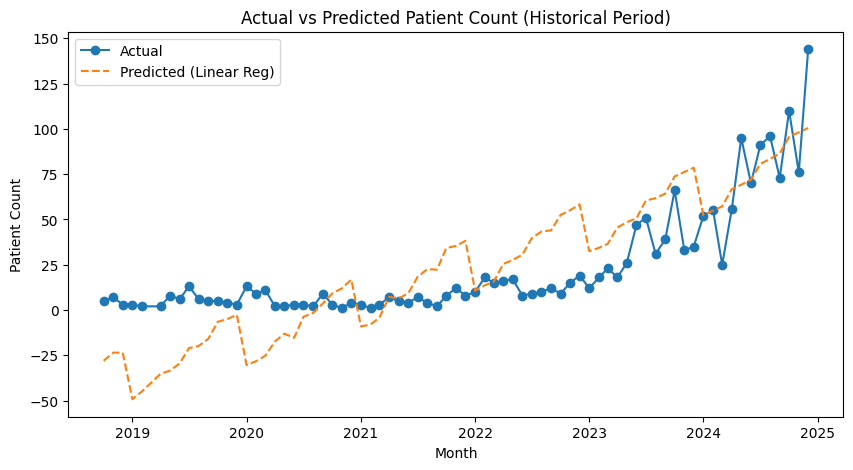

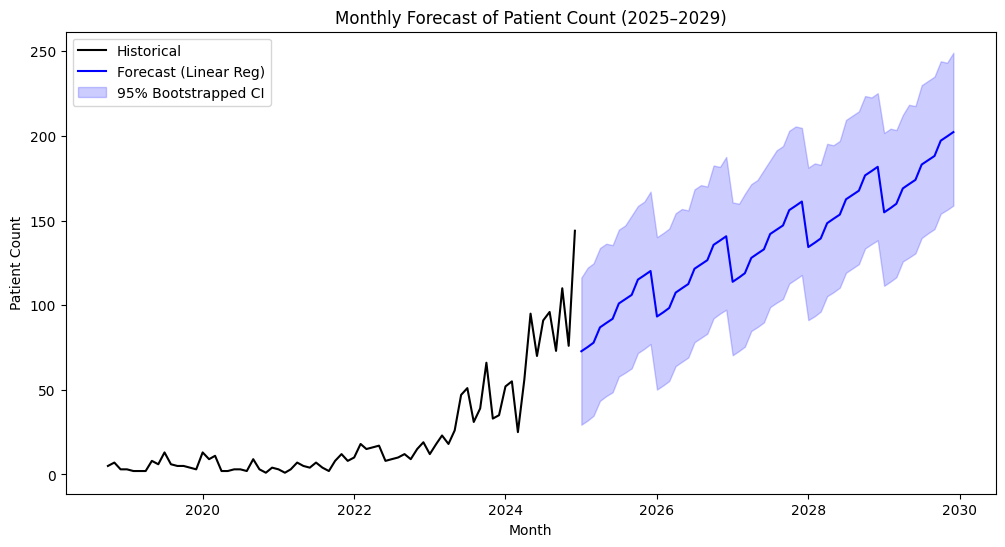

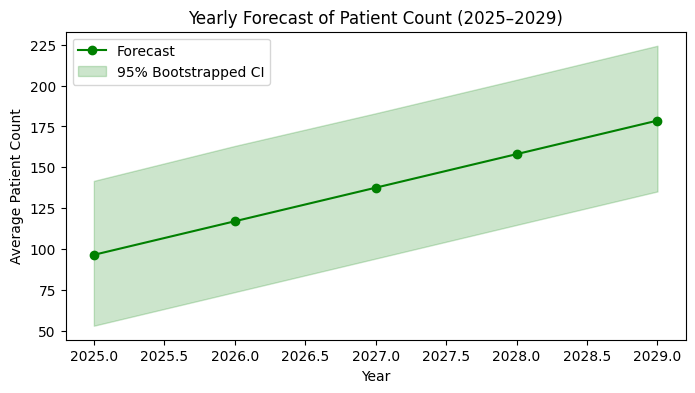

Forecasting complete. Monthly and yearly forecasts saved.


In [ ]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

# --- 1. Load Data ---
df_long = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_long.csv", parse_dates=['month'])
monthly_counts = df_long.groupby('month')['OPIP_CODE'].nunique().reset_index()
monthly_counts.rename(columns={'OPIP_CODE': 'patient_count'}, inplace=True)

# Load the monthly temporal data which contains the features used for training the LR model
# We need this to identify the features the LR model was trained on.
df_temporal = pd.read_csv("drive/MyDrive/Rulinga II/DIAGNOSIS_RESULTS_monthly_temporal.csv", parse_dates=['month'])

# --- 2. Load Trained Model ---
model_lr = joblib.load("drive/MyDrive/Rulinga II/lr_model.pkl")

# Define the features the Linear Regression model was trained on
# This should match the features_lr defined in the model training
features_lr = ['month_num', 'year', 'quarter', 'AGE', 'GENDER', 'ALT_LEVEL', 'VIRAL_LOAD']


# --- 3. Prepare Historical Features ---
# Merge monthly counts with the temporal features to get all features for historical prediction
# We need the patient-level data to calculate the average features per month
historical_df_merged = pd.merge(df_long, monthly_counts, on='month', how='left')

# Aggregate patient-level features to monthly level by taking the mean/mode
historical_features_agg = historical_df_merged.groupby('month').agg({
    'patient_count': 'first', # Keep the monthly count
    'AGE': 'mean',
    'ALT_LEVEL': 'mean',
    'VIRAL_LOAD': 'mean',
    'GENDER': lambda x: x.mode()[0] if not x.mode().empty else (historical_df_merged['GENDER'].mode()[0] if not historical_df_merged['GENDER'].mode().empty else 1) # Use mode, handle empty
}).reset_index()

# Add year, month_num, and quarter features to the aggregated historical data
historical_features_agg['year'] = historical_features_agg['month'].dt.year
historical_features_agg['month_num'] = historical_features_agg['month'].dt.month
historical_features_agg['quarter'] = historical_features_agg['month'].dt.quarter


# Prepare historical features for prediction, ensuring all features are present and in the correct order
X_hist = historical_features_agg[features_lr].replace([np.inf, -np.inf], np.nan)

# Impute missing values in historical features (if any) with the mean of each column
for col in features_lr:
    if X_hist[col].isnull().any():
        mean_val = X_hist[col].mean()
        X_hist[col].fillna(mean_val, inplace=True)

y_hist = historical_features_agg['patient_count']

# --- 4. Predict Historical (Actual vs Predicted) ---
historical_features_agg['predicted'] = model_lr.predict(X_hist)

# --- 5. Prepare Future Data (2025–2029) ---
future_months = pd.date_range(start="2025-01-01", end="2029-12-01", freq="MS")
future_df = pd.DataFrame({'month': future_months})
future_df['year'] = future_df['month'].dt.year
future_df['month_num'] = future_df['month'].dt.month
future_df['quarter'] = future_df['month'].dt.quarter

# Impute future patient-level features with the mean/mode of the historical aggregated features
for col in ['AGE', 'ALT_LEVEL', 'VIRAL_LOAD']:
    future_df[col] = historical_features_agg[col].mean() # Use mean from historical aggregated data
# For gender, use the mode of the historical aggregated data
future_df['GENDER'] = historical_features_agg['GENDER'].mode()[0] if not historical_features_agg['GENDER'].mode().empty else 1


# Ensure future features are in the same order as training features
X_future = future_df[features_lr].replace([np.inf, -np.inf], np.nan)

# Impute missing values in future features (if any) with the mean of each column
for col in features_lr:
    if X_future[col].isnull().any():
        mean_val = X_future[col].mean()
        X_future[col].fillna(mean_val, inplace=True)


# --- 6. Forecast Future Values ---
future_df['forecast'] = model_lr.predict(X_future)

# --- 7. Bootstrapped Confidence Intervals ---
# Use residuals from the historical predictions
residuals = y_hist - historical_features_agg['predicted']
n_boot = 1000
boot_preds = np.zeros((len(future_df), n_boot))

np.random.seed(42)
for i in range(n_boot):
    # Sample residuals for future length with replacement
    sample_residuals = np.random.choice(residuals, size=len(future_df), replace=True)
    # Add sampled residuals to the future forecast
    boot_preds[:, i] = future_df['forecast'] + sample_residuals


future_df['lower_ci'] = np.percentile(boot_preds, 2.5, axis=1)
future_df['upper_ci'] = np.percentile(boot_preds, 97.5, axis=1)

# Ensure confidence intervals are not negative
future_df['lower_ci'] = future_df['lower_ci'].clip(lower=0)
future_df['upper_ci'] = future_df['upper_ci'].clip(lower=0)
future_df['forecast'] = future_df['forecast'].clip(lower=0)


# --- 8. Visualisations ---
# Actual vs Predicted (Historical Period)
plt.figure(figsize=(10,5))
plt.plot(historical_features_agg['month'], historical_features_agg['patient_count'], label='Actual', marker='o')
plt.plot(historical_features_agg['month'], historical_features_agg['predicted'], label='Predicted (Linear Reg)', linestyle='--')
plt.title('Actual vs Predicted Patient Count (Historical Period)')
plt.xlabel('Month')
plt.ylabel('Patient Count')
plt.legend()
plt.grid(False)
plt.show()

# Monthly Forecast (2025–2029)
plt.figure(figsize=(12,6))
plt.plot(historical_features_agg['month'], historical_features_agg['patient_count'], label='Historical', color='black')
plt.plot(future_df['month'], future_df['forecast'], label='Forecast (Linear Reg)', color='blue')
plt.fill_between(future_df['month'], future_df['lower_ci'], future_df['upper_ci'],
                 color='blue', alpha=0.2, label='95% Bootstrapped CI')
plt.title('Monthly Forecast of Patient Count (2025–2029)')
plt.xlabel('Month')
plt.ylabel('Patient Count')
plt.legend()
plt.grid(False)
plt.show()

# Yearly Forecast (2025–2029)
yearly_forecast = future_df.groupby('year')[['forecast','lower_ci','upper_ci']].mean().reset_index()

plt.figure(figsize=(8,4))
plt.plot(yearly_forecast['year'], yearly_forecast['forecast'], marker='o', color='green', label='Forecast')
plt.fill_between(yearly_forecast['year'], yearly_forecast['lower_ci'], yearly_forecast['upper_ci'],
                 color='green', alpha=0.2, label='95% Bootstrapped CI')
plt.title('Yearly Forecast of Patient Count (2025–2029)')
plt.xlabel('Year')
plt.ylabel('Average Patient Count')
plt.grid(False)
plt.legend()
plt.show()

# --- 9. Save Results ---
future_df.to_csv("drive/MyDrive/Rulinga II/five_year_forecast_monthly.csv", index=False)
yearly_forecast.to_csv("drive/MyDrive/Rulinga II/five_year_forecast_yearly.csv", index=False)

print("Forecasting complete. Monthly and yearly forecasts saved.")